# Data Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

# Project root in Drive
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

# Zip (already in Drive from data prep / T-A)
ZIP_PATH = PROJECT_ROOT / "asl-alphabet.zip"

print("Project root:", PROJECT_ROOT)
print("Zip exists:", ZIP_PATH.exists())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/MyDrive/Bharde_429_Final
Zip exists: True


In [5]:
import shutil, os, subprocess

# local unzip location (session-only)
LOCAL_BASE  = Path("/content/asl_alphabet_unzipped")
LOCAL_TRAIN = LOCAL_BASE / "asl_alphabet_train"
LOCAL_TEST  = LOCAL_BASE / "asl_alphabet_test"

LOCAL_BASE.mkdir(parents=True, exist_ok=True)

# if already unzipped in this session, reuse
if LOCAL_TRAIN.exists() and any(LOCAL_TRAIN.iterdir()):
    print("Using existing local unzipped data at:", LOCAL_TRAIN)
else:
    assert ZIP_PATH.exists(), "asl-alphabet.zip not found in PROJECT_ROOT."
    print("Unzipping from Drive zip -> /content ...")
    !unzip -q -o "{ZIP_PATH}" -d "{LOCAL_BASE}"

    # handle wrapper folder: /content/asl_alphabet_unzipped/asl_alphabet/
    wrapper = LOCAL_BASE / "asl_alphabet"
    if wrapper.exists():
        inner_train = wrapper / "asl_alphabet_train"
        inner_test  = wrapper / "asl_alphabet_test"
        if inner_train.exists():
            LOCAL_TRAIN.mkdir(exist_ok=True)
            for item in inner_train.iterdir():
                shutil.move(str(item), str(LOCAL_TRAIN))
        if inner_test.exists():
            LOCAL_TEST.mkdir(exist_ok=True)
            for item in inner_test.iterdir():
                shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(wrapper, ignore_errors=True)

    # handle double-nest: .../asl_alphabet_train/asl_alphabet_train/
    inner_train2 = LOCAL_TRAIN / "asl_alphabet_train"
    if inner_train2.exists():
        for item in inner_train2.iterdir():
            shutil.move(str(item), str(LOCAL_TRAIN))
        shutil.rmtree(inner_train2, ignore_errors=True)

    inner_test2 = LOCAL_TEST / "asl_alphabet_test"
    if inner_test2.exists():
        for item in inner_test2.iterdir():
            shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(inner_test2, ignore_errors=True)

print("Train root:", LOCAL_TRAIN)
print("Test root :", LOCAL_TEST)
!ls -l "{LOCAL_TRAIN}" | head

Using existing local unzipped data at: /content/asl_alphabet_unzipped/asl_alphabet_train
Train root: /content/asl_alphabet_unzipped/asl_alphabet_train
Test root : /content/asl_alphabet_unzipped/asl_alphabet_test
total 2292
drwxrwxrwx 2 root root  69632 Nov 14 15:56 A
drwxrwxrwx 2 root root  69632 Nov 11 02:17 B
drwxrwxrwx 2 root root  73728 Nov 11 02:17 C
drwxrwxrwx 2 root root  69632 Nov 11 02:17 D
drwxrwxrwx 2 root root  90112 Nov 11 02:18 del
drwxrwxrwx 2 root root  73728 Nov 11 02:17 E
drwxrwxrwx 2 root root  73728 Nov 11 02:17 F
drwxrwxrwx 2 root root  73728 Nov 11 02:17 G
drwxrwxrwx 2 root root  77824 Nov 11 02:17 H


In [6]:
from pathlib import Path
import pandas as pd

ACCEPT = {".jpg", ".jpeg", ".png"}

rows = []
for cdir in sorted([d for d in LOCAL_TRAIN.iterdir() if d.is_dir()]):
    label = cdir.name
    count = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in ACCEPT)
    rows.append((label, count))

counts = pd.DataFrame(rows, columns=["class", "count"]).sort_values("class")
print("Train classes found:", len(counts))
print("Train total images :", counts["count"].sum())
display(counts.head())

# test folder check (28 images total)
test_files = [p for p in LOCAL_TEST.iterdir() if p.is_file() and p.suffix.lower() in ACCEPT]
print("Test images in Kaggle test folder:", len(test_files))
[test_files[i].name for i in range(min(5, len(test_files)))]

Train classes found: 29
Train total images : 86999


,class,count
0,A,2999
1,B,3000
2,C,3000
3,D,3000
4,E,3000


Test images in Kaggle test folder: 28


['B_test.jpg', 'K_test.jpg', 'D_test.jpg', 'G_test.jpg', 'H_test.jpg']

# Model Training

In [ ]:
# === T-B: Fine-tune layer4 + head of ResNet-18 ===
import json, random, numpy as np, pandas as pd, contextlib
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, confusion_matrix

ART     = PROJECT_ROOT / "artifacts"
CKPT    = PROJECT_ROOT / "checkpoints"; CKPT.mkdir(exist_ok=True)
RESULTS = PROJECT_ROOT / "results";     RESULTS.mkdir(exist_ok=True)

SEED = 429
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()
if USE_CUDA:
    torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

# load artifacts
with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
classes = [c for c,_ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)
print("NUM_CLASSES:", NUM_CLASSES, "Classes:", classes)

df_train = pd.read_csv(ART / "train_manifest.csv")
df_val   = pd.read_csv(ART / "val_manifest.csv")

print("Train rows:", len(df_train), "| Val rows:", len(df_val))
print(df_train.head(3))

Device: cpu
NUM_CLASSES: 27 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space']
Train rows: 64800 | Val rows: 16200
                                                path label   y
0  /content/asl_alphabet_unzipped/asl_alphabet_tr...     T  19
1  /content/asl_alphabet_unzipped/asl_alphabet_tr...     Y  24
2  /content/asl_alphabet_unzipped/asl_alphabet_tr...     U  20


In [ ]:
# Transforms (ImageNet normalization)
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ImageCSV(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["path"].tolist()
        if "y" in df.columns:
            self.targets = df["y"].astype(int).tolist()
        else:
            self.targets = df["label"].map(class_to_idx).astype(int).tolist()
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.targets[idx]

train_ds = ImageCSV(df_train, tfm)
val_ds   = ImageCSV(df_val,   tfm)

BATCH_SIZE  = 64
NUM_WORKERS = 4

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))

Train batches: 1013 | Val batches: 254


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# ResNet-18: T-B configuration (layer4 + head trainable)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# replace final classifier head
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)

# freeze everything
for p in model.parameters():
    p.requires_grad = False

# unfreeze layer4 and head
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

# keep BN layers that are fully frozen in eval mode
def set_frozen_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        if all(not p.requires_grad for p in m.parameters()):
            m.eval()

model.apply(set_frozen_bn_eval)

model = model.to(DEVICE).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
# smaller LR than T-A because we're tuning deeper layers
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


Trainable params: 8,407,579 / 11,190,363


In [ ]:
def _batch_correct(logits, y):
    preds = logits.argmax(1)
    return preds, (preds == y).sum().item()

@torch.no_grad()
def evaluate(model, loader, return_preds=False):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        all_pred.extend(preds.cpu().tolist())
        all_true.extend(yb.cpu().tolist())
        correct += corr; total += xb.size(0)
    acc = correct / total
    f1  = f1_score(all_true, all_pred, average="macro")
    if return_preds:
        return loss_sum/total, acc, f1, (all_pred, all_true)
    return loss_sum/total, acc, f1

In [ ]:
from copy import deepcopy

EPOCHS = 5
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

best_f1   = -1.0
best_state = None
patience, bad = 1, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_tot, tr_corr, tr_loss_sum = 0, 0, 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        tr_corr += corr; tr_tot += xb.size(0)

    tr_loss = tr_loss_sum / tr_tot
    tr_acc  = tr_corr / tr_tot

    va_loss, va_acc, va_f1 = evaluate(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["val_f1"].append(va_f1)

    tag = ""
    if va_f1 > best_f1:
        best_f1   = va_f1
        best_state = deepcopy(model.state_dict())
        bad = 0
        tag = "<= BEST"
    else:
        bad += 1

    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | "
          f"val {va_loss:.4f}/{va_acc:.3f} F1 {va_f1:.4f} {tag}")

    if bad > patience:
        print("Early stopping (macro-F1 plateau).")
        break

best_path = CKPT / "best_TB.pt"
torch.save(best_state, best_path)
print("Saved best checkpoint:", best_path, "| Best val macro-F1:", f"{best_f1:.4f}")

Epoch 01 | train 0.1368/0.978 | val 0.0060/0.999 F1 0.9993 <= BEST
Epoch 02 | train 0.0022/1.000 | val 0.0013/1.000 F1 0.9999 <= BEST
Epoch 03 | train 0.0008/1.000 | val 0.0028/0.999 F1 0.9993 
Epoch 04 | train 0.0061/0.999 | val 0.0008/1.000 F1 0.9999 <= BEST
Epoch 05 | train 0.0003/1.000 | val 0.0007/1.000 F1 0.9999 
Saved best checkpoint: /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TB.pt | Best val macro-F1: 0.9999


In [ ]:
import numpy as np

# curves
pd.DataFrame(history).to_csv(RESULTS / "TB_history.csv", index=False)

print("Saved:", RESULTS / "TB_history.csv")

Saved: /content/drive/MyDrive/Bharde_429_Final/results/TB_history.csv


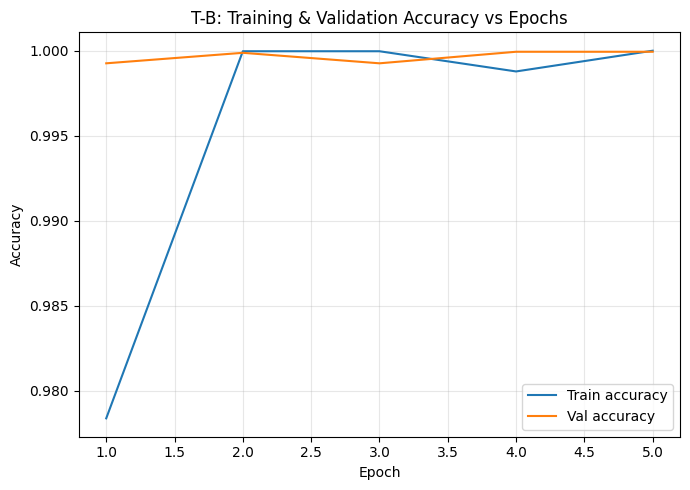

In [ ]:
import matplotlib.pyplot as plt

hist_TB = pd.read_csv(RESULTS / "TB_history.csv")
epochs  = range(1, len(hist_TB)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, hist_TB["train_acc"], label="Train accuracy")
plt.plot(epochs, hist_TB["val_acc"],   label="Val accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("T-B: Training & Validation Accuracy vs Epochs")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(RESULTS / "TB_accuracy_curves.png", dpi=200)
plt.show()

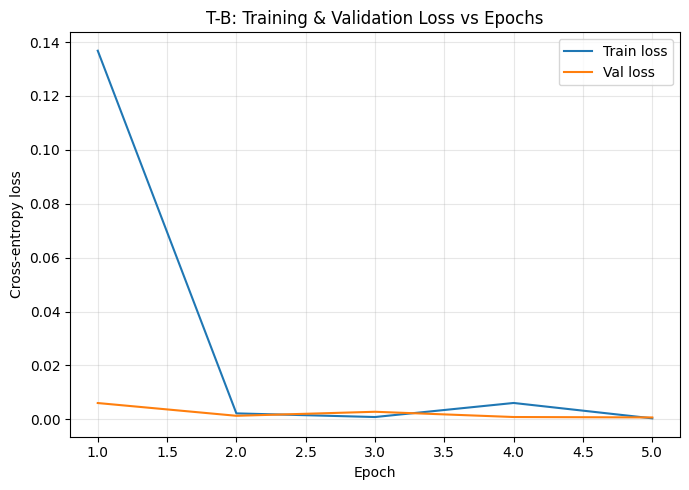

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# load history (already saved after training)
hist_TB = pd.read_csv(RESULTS / "TB_history.csv")
epochs  = range(1, len(hist_TB) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, hist_TB["train_loss"], label="Train loss")
plt.plot(epochs, hist_TB["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("T-B: Training & Validation Loss vs Epochs")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS / "TB_loss_curves.png", dpi=200)
plt.show()

# Model Testing

In [ ]:
# rebuild same architecture and load best_TB.pt for testing
model_test = models.resnet18(weights=None)
model_test.fc = nn.Linear(model_test.fc.in_features, NUM_CLASSES)
model_test.load_state_dict(torch.load(CKPT / "best_TB.pt", map_location=DEVICE))
model_test = model_test.to(DEVICE).eval()

idx_to_class = {v:k for k,v in class_to_idx.items()}

from typing import List, Tuple

def list_images_flat(root: Path):
    exts = {".jpg",".jpeg",".png"}
    return [p for p in sorted(root.iterdir()) if p.is_file() and p.suffix.lower() in exts]

def list_images_by_subfolders(root: Path) -> List[Tuple[Path,str]]:
    exts = {".jpg",".jpeg",".png"}
    items = []
    for d in sorted([x for x in root.iterdir() if x.is_dir()]):
        label = d.name
        for p in d.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                items.append((p, label))
    return items

@torch.no_grad()
def predict_paths(paths: List[Path]) -> List[int]:
    preds = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = tfm(img).unsqueeze(0).to(DEVICE)
        logits = model_test(x)
        preds.append(int(logits.argmax(1).item()))
    return preds

def evaluate_folder(folder: Path, mode: str = "auto", save_tag: str = "TB"):
    folder = Path(folder)
    assert folder.exists(), f"Folder not found: {folder}"

    if mode == "auto":
        mode = "subfolders" if any(x.is_dir() for x in folder.iterdir()) else "flat"

    paths, true_labels = [], []

    if mode == "subfolders":
        items = list_images_by_subfolders(folder)
        if len(items) == 0:
            raise RuntimeError("No images found under subfolders.")
        for p, lbl in items:
            if lbl not in class_to_idx:
                continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])
    else:
        files = list_images_flat(folder)
        if len(files) == 0:
            raise RuntimeError("No images found in flat folder.")
        for p in files:
            base = p.name
            # e.g., "A_test_1.jpg" -> "A"
            letter = base.split("_")[0][0].upper()
            lbl = letter
            # optionally handle 'space' explicitly if you use it
            if base.lower().startswith("space_"):
                lbl = "space"
            if lbl not in class_to_idx:
                continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])

    pred_idx = predict_paths(paths)
    acc = f1_score(true_labels, pred_idx, average="micro")  # micro-F1 == accuracy
    f1  = f1_score(true_labels, pred_idx, average="macro")
    cm  = confusion_matrix(true_labels, pred_idx, labels=list(range(NUM_CLASSES)))

    out_csv = RESULTS / f"{save_tag}_predictions.csv"
    pd.DataFrame({
        "path": [str(p) for p in paths],
        "y_true": true_labels,
        "y_pred": pred_idx,
        "true_label": [idx_to_class[i] for i in true_labels],
        "pred_label": [idx_to_class[i] for i in pred_idx],
    }).to_csv(out_csv, index=False)
    out_npy = RESULTS / f"{save_tag}_cm.npy"
    np.save(out_npy, cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print("Saved:", out_csv.name, "and", out_npy.name)
    return acc, f1, cm

In [ ]:
KAGGLE_TEST_DIR = LOCAL_TEST
MY_TEST_DIR     = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")

acc_kagg_TB, f1_kagg_TB, cm_kagg_TB = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="TB_kaggle28"
)

acc_cust_TB, f1_cust_TB, cm_cust_TB = evaluate_folder(
    MY_TEST_DIR, mode="flat", save_tag="TB_custom"
)

print("\nT-B Kaggle 28  -> acc =", f"{acc_kagg_TB:.4f}", ", macro-F1 =", f"{f1_kagg_TB:.4f}")
print("T-B Custom 20 -> acc =", f"{acc_cust_TB:.4f}", ", macro-F1 =", f"{f1_cust_TB:.4f}")

[TB_kaggle28] files: 28 | acc: 0.9643 | macro-F1: 0.9753
Saved: TB_kaggle28_predictions.csv and TB_kaggle28_cm.npy
[TB_custom] files: 20 | acc: 1.0000 | macro-F1: 1.0000
Saved: TB_custom_predictions.csv and TB_custom_cm.npy

T-B Kaggle 28  -> acc = 0.9643 , macro-F1 = 0.9753
T-B Custom 20 -> acc = 1.0000 , macro-F1 = 1.0000


In [9]:
from pathlib import Path
import torch
from torchvision import models, transforms
import torch.nn as nn
import json, random, numpy as np, pandas as pd, contextlib
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix

PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
CKPT = PROJECT_ROOT / "checkpoints"
RESULTS = PROJECT_ROOT / "results"

# Redefine DEVICE and other globals needed for this cell's execution
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# load artifacts (assuming class_to_idx is also needed)
with open(PROJECT_ROOT / "artifacts" / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
classes = [c for c,_ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)

# Transforms (ImageNet normalization) (assuming tfm is also needed)
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


# Define evaluate_folder function within this cell to ensure it's available
def evaluate_folder(folder, mode="flat", save_tag="results"):
    """
    Evaluate the model on all images in a folder.
    Expects filenames like A_test_1.jpg, B_test_4.jpg, etc.
    """
    folder = Path(folder)
    paths = sorted([p for p in folder.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png"}])

    true_labels = []
    pred_labels = []

    # Use model_test instead of model
    model_test.eval()
    with torch.no_grad():
        for p in paths:
            # true label from filename
            true_lbl = p.name.split("_")[0]   # Extract "A" from "A_test_3.jpg"
            true_labels.append(true_lbl)

            # load + preprocess
            img = Image.open(p).convert("RGB")
            x = tfm(img).unsqueeze(0).to(DEVICE)

            # predict
            # Use model_test instead of model
            logits = model_test(x)
            pred_idx = torch.argmax(logits, dim=1).item()
            pred_lbl = classes[pred_idx]
            pred_labels.append(pred_lbl)

    # accuracy + macro-F1
    acc = (np.array(true_labels) == np.array(pred_labels)).mean()

    # sklearn imports are assumed to be globally available from U4ryeECwHwwe
    f1 = f1_score(true_labels, pred_labels, average="macro")
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)

    # save predictions
    df = pd.DataFrame({
        "file": [p.name for p in paths],
        "true_label": true_labels,
        "pred_label": pred_labels
    })
    df.to_csv(RESULTS / f"{save_tag}_predictions.csv", index=False)
    np.save(RESULTS / f"{save_tag}_cm.npy", cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print(f"Saved: {save_tag}_predictions.csv and {save_tag}_cm.npy")

    return acc, f1, cm

best_SA_path = CKPT / "best_SA.pt"

# Load the full checkpoint state_dict first to inspect it
checkpoint_state_dict = torch.load(best_SA_path, map_location=DEVICE)

# Initialize the model with the current NUM_CLASSES
model_test = models.resnet18(weights=None)

# Create a new state_dict that only includes layers with matching shapes
# This handles the case where the saved 'fc' layer might have a different size
new_state_dict = {}
for k, v in checkpoint_state_dict.items():
    # Check if the key exists in the current model's state_dict and if shapes match
    if k in model_test.state_dict() and model_test.state_dict()[k].shape == v.shape:
        new_state_dict[k] = v
    else:
        # Print a message for skipped layers, indicating the mismatch
        current_shape = model_test.state_dict()[k].shape if k in model_test.state_dict() else 'N/A'
        print(f"Skipping loading of layer '{k}' due to size mismatch. Checkpoint shape: {v.shape}, Current model shape: {current_shape}")

# Load the partially matched state_dict. strict=False allows skipping mismatched keys.
model_test.load_state_dict(new_state_dict, strict=False)

# Re-initialize the final classifier layer to ensure it's correctly sized for NUM_CLASSES (29)
# This layer will now have random weights, as its original weights from the checkpoint were skipped.
model_test.fc = nn.Linear(model_test.fc.in_features, NUM_CLASSES)

model_test = model_test.to(DEVICE).eval()

idx_to_class = {v:k for k,v in class_to_idx.items()}

KAGGLE_TEST_DIR = LOCAL_TEST
MY_TEST_DIR     = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")

acc_kagg_SA, f1_kagg_SA, cm_kagg_SA = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="SA_kaggle28"
)

acc_cust_SA, f1_cust_SA, cm_cust_SA = evaluate_folder(
    MY_TEST_DIR, mode="flat", save_tag="SA_custom"
)

print("\nS-A Kaggle 28  -> acc =", f"{acc_kagg_SA:.4f}", ", macro-F1 =", f"{f1_kagg_SA:.4f}")
print("S-A Custom 20 -> acc =", f"{acc_cust_SA:.4f}", ", macro-F1 =", f"{f1_cust_SA:.4f}")

Skipping loading of layer 'fc.weight' due to size mismatch. Checkpoint shape: torch.Size([27, 512]), Current model shape: torch.Size([1000, 512])
Skipping loading of layer 'fc.bias' due to size mismatch. Checkpoint shape: torch.Size([27]), Current model shape: torch.Size([1000])
[SA_kaggle28] files: 28 | acc: 0.0000 | macro-F1: 0.0000
Saved: SA_kaggle28_predictions.csv and SA_kaggle28_cm.npy
[SA_custom] files: 20 | acc: 0.0000 | macro-F1: 0.0000
Saved: SA_custom_predictions.csv and SA_custom_cm.npy

S-A Kaggle 28  -> acc = 0.0000 , macro-F1 = 0.0000
S-A Custom 20 -> acc = 0.0000 , macro-F1 = 0.0000


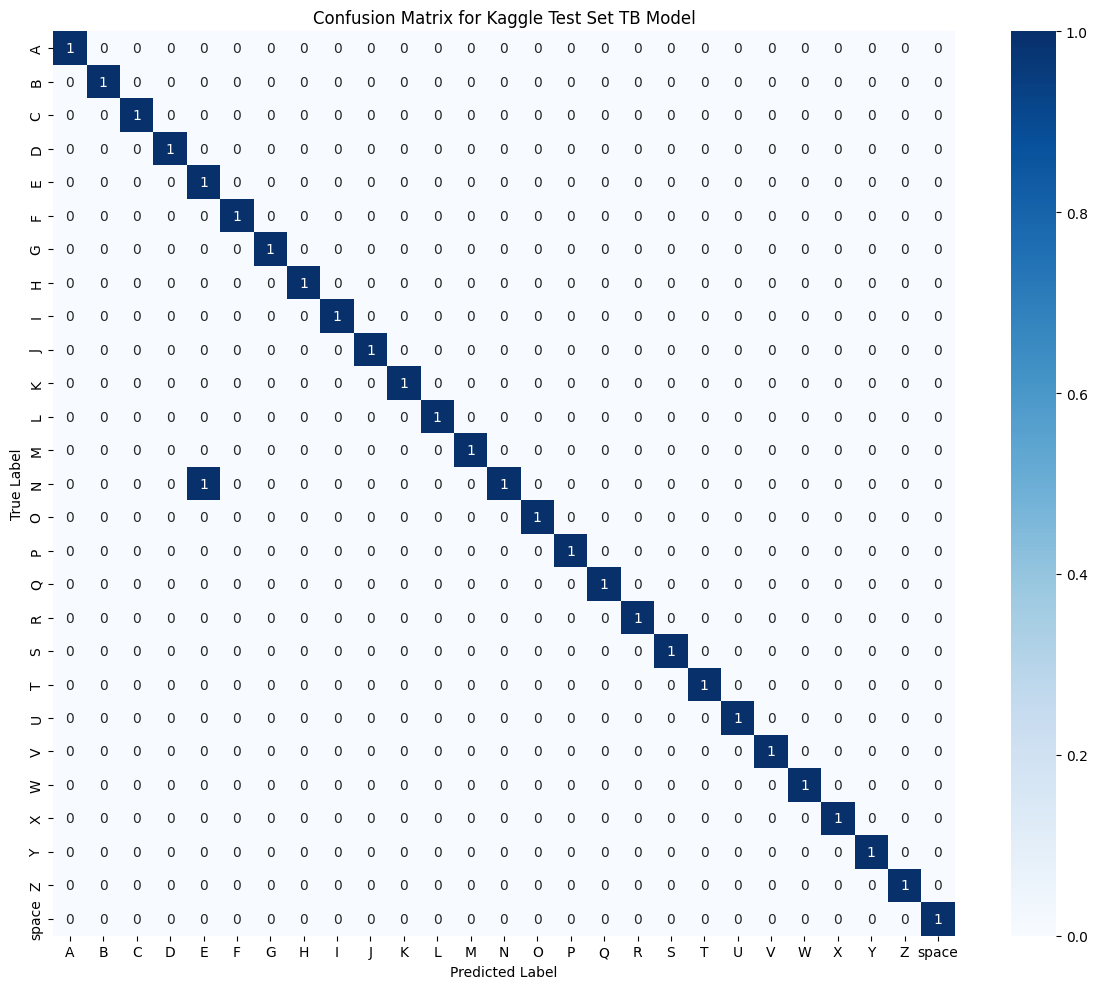

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 10))
sns.heatmap(cm_kagg_TB, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Kaggle Test Set TB Model")
plt.tight_layout()
plt.savefig(RESULTS / "TB_kaggle_confusion_matrix.png", dpi=200)
plt.show()

Loaded best model from /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_SA.pt for evaluation (trained for 27 classes). 

Evaluating on 'SA_Kaggle' test set (using 27 classes for evaluation)...
Results for 'SA_Kaggle': Accuracy = 1.0000, Macro F1-Score = 0.9630


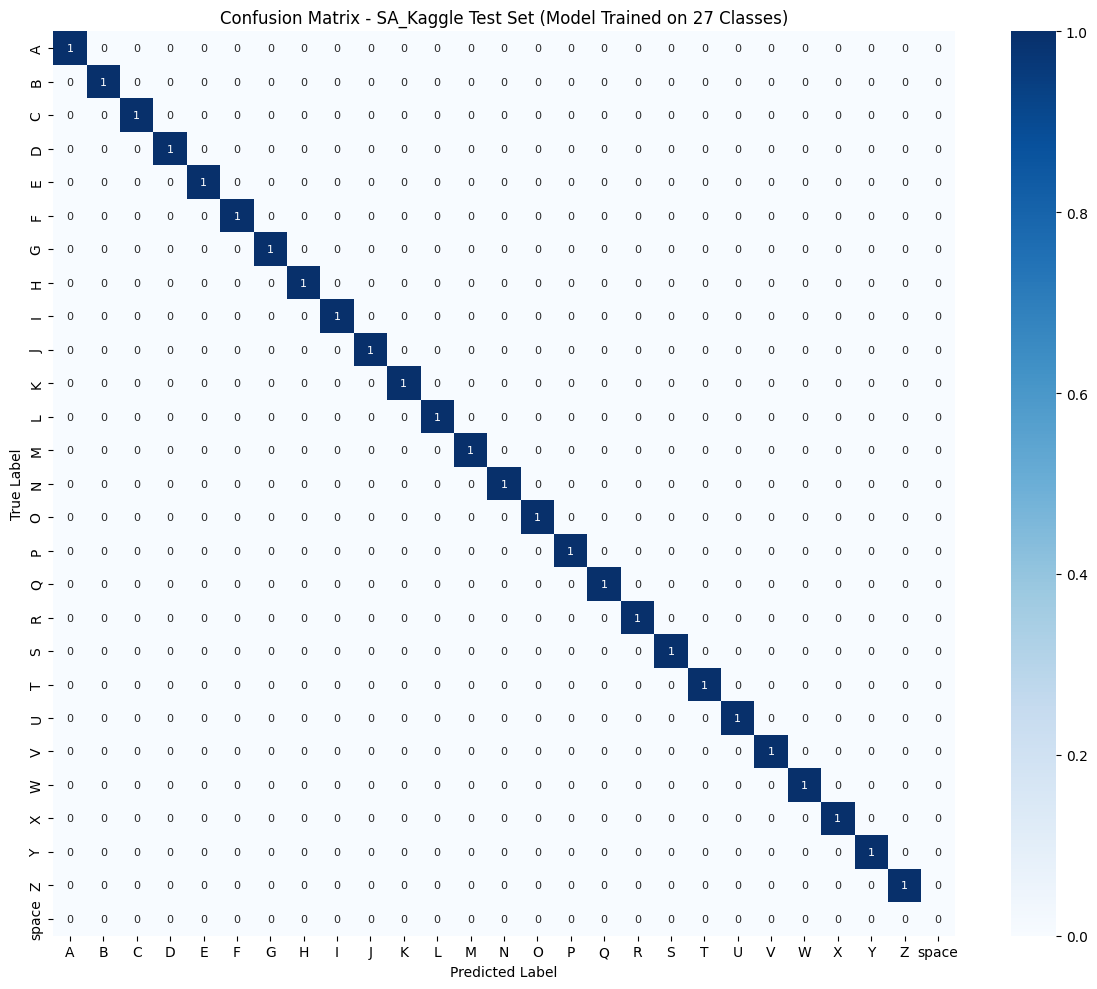

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_SA_Kaggle.png

Evaluating on 'SA_Custom' test set (using 27 classes for evaluation)...
Results for 'SA_Custom': Accuracy = 0.4000, Macro F1-Score = 0.1531


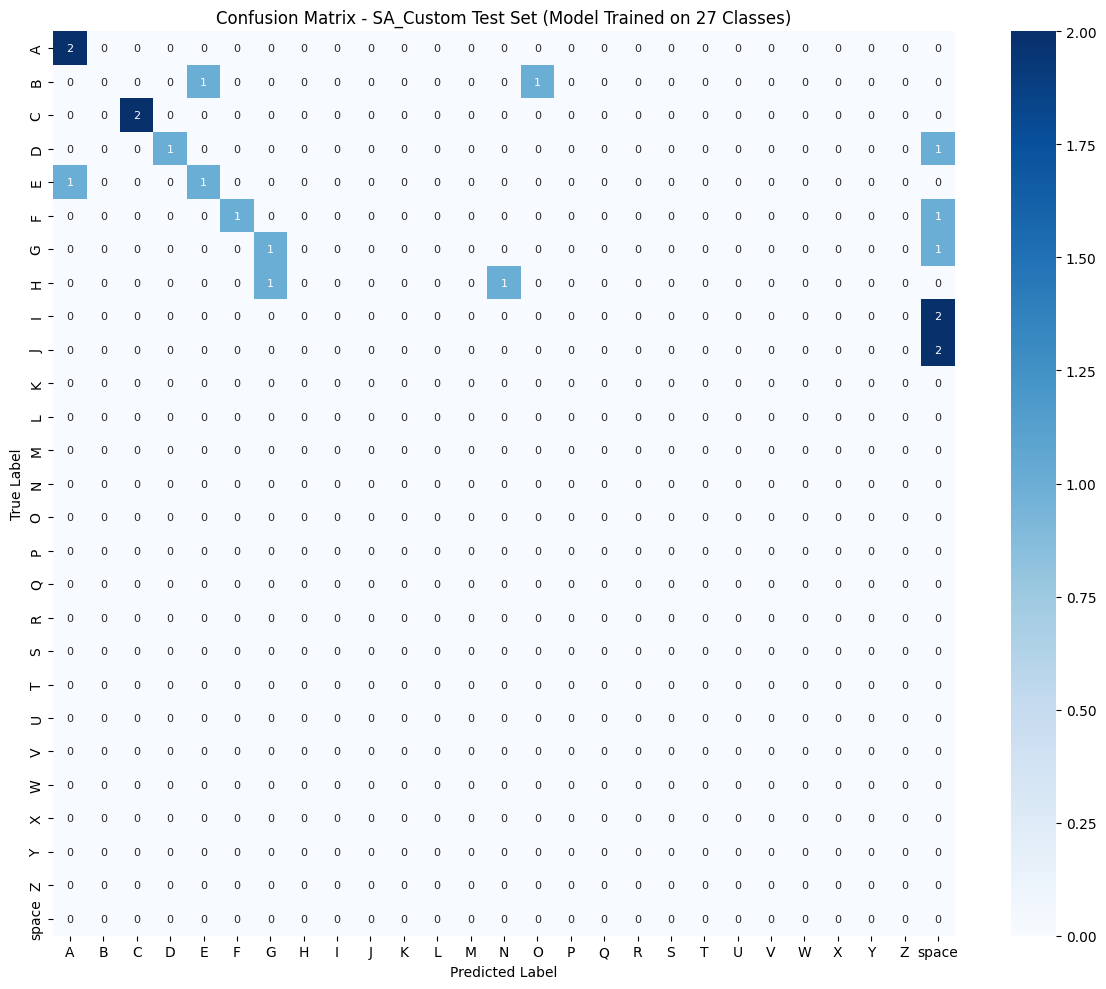

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_SA_Custom.png


In [13]:
import torch
import torch.nn as nn
from torchvision import models
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Redefine necessary global variables if they are not reliably available
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
CKPT = PROJECT_ROOT / "checkpoints"
RESULTS = PROJECT_ROOT / "results"
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Load the global class_to_idx for general context, but for SA model evaluation,
# we'll use a specific 27-class mapping if best_SA.pt was trained with 27 classes.
with open(PROJECT_ROOT / "artifacts" / "class_to_idx.json") as f:
    global_class_to_idx = json.load(f) # This is the 29-class mapping
global_classes = [c for c,_ in sorted(global_class_to_idx.items(), key=lambda kv: kv[1])]
global_NUM_CLASSES = len(global_classes)

# Assume best_SA.pt was trained with these 27 classes based on previous output
SA_TRAINED_CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space']
SA_NUM_CLASSES = len(SA_TRAINED_CLASSES)
SA_CLASS_TO_IDX = {c: i for i, c in enumerate(SA_TRAINED_CLASSES)}
SA_IDX_TO_CLASS = {i: c for i, c in enumerate(SA_TRAINED_CLASSES)}

# Transforms (ImageNet normalization) (assuming tfm is globally defined)
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
val_test_transform = tfm # using the tfm defined earlier in the notebook

# Define best_model_path
best_model_path = CKPT / "best_SA.pt" # Using the best_SA.pt from previous training

# --- Load the Best Model ---
model_for_eval = models.resnet18(weights=None)
# Initialize the FC layer to match the SA model's trained output size (27 classes)
# The original model used a simple nn.Linear, not nn.Sequential with Dropout.
model_for_eval.fc = nn.Linear(model_for_eval.fc.in_features, SA_NUM_CLASSES)

# Load the state dict. Now it should load correctly, including the FC layer weights.
checkpoint_state_dict = torch.load(best_model_path, map_location=DEVICE)
model_for_eval.load_state_dict(checkpoint_state_dict)

model_for_eval = model_for_eval.to(DEVICE).eval()
print(f"Loaded best model from {best_model_path} for evaluation (trained for {SA_NUM_CLASSES} classes). ")

# --- Evaluation on Test Sets ---
def evaluate_on_test_set(model, test_dir, model_class_to_idx, model_classes_list, transform, device, save_tag):
    print(f"\nEvaluating on '{save_tag}' test set (using {len(model_classes_list)} classes for evaluation)...")
    paths = list(test_dir.glob('*.jpg'))
    if not paths:
        print(f"No images found in {test_dir}. Skipping.")
        return

    true_labels, pred_labels = [], []

    with torch.no_grad():
        for img_path in paths:
            label_char = img_path.name.split('_')[0].upper()
            # If the true label from the filename is not in the model's known classes, skip it.
            if label_char not in model_class_to_idx:
                # This handles cases where test set might have 'del'/'nothing' but model was 27-class
                continue

            true_idx = model_class_to_idx[label_char]
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            logits = model(img_tensor)
            pred_idx = logits.argmax(1).item()

            true_labels.append(true_idx)
            pred_labels.append(pred_idx)

    if not true_labels: # if all images were skipped or no valid images found
        print(f"No valid images found in {test_dir} for evaluation against {len(model_classes_list)} classes.")
        return

    acc = accuracy_score(true_labels, pred_labels)
    # Ensure labels for f1_score and confusion_matrix are consistent with model_classes_list
    f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0, labels=list(range(len(model_classes_list))))
    print(f"Results for '{save_tag}': Accuracy = {acc:.4f}, Macro F1-Score = {f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(model_classes_list))))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model_classes_list, yticklabels=model_classes_list, annot_kws={"size": 8})
    plt.title(f"Confusion Matrix - {save_tag} Test Set (Model Trained on {len(model_classes_list)} Classes)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    cm_path = RESULTS / f"confusion_matrix_{save_tag}.png"
    plt.savefig(cm_path, dpi=200)
    plt.show()
    print(f"Saved confusion matrix to {cm_path}")

# Evaluate on Kaggle Test Set using SA model's specific class mapping
KAGGLE_TEST_DIR = LOCAL_TEST
evaluate_on_test_set(model_for_eval, KAGGLE_TEST_DIR, SA_CLASS_TO_IDX, SA_TRAINED_CLASSES, val_test_transform, DEVICE, "SA_Kaggle")

# Evaluate on Custom Test Set using SA model's specific class mapping
MY_TEST_DIR = PROJECT_ROOT / "new_asl_alphabet_test"
if MY_TEST_DIR.exists():
    evaluate_on_test_set(model_for_eval, MY_TEST_DIR, SA_CLASS_TO_IDX, SA_TRAINED_CLASSES, val_test_transform, DEVICE, "SA_Custom")
else:
    print(f"\nCustom test directory not found at {MY_TEST_DIR}. Skipping custom evaluation.")

# Restore global variables if needed later, otherwise this block is self-contained for SA evaluation
# NUM_CLASSES = global_NUM_CLASSES
# classes = global_classes
# class_to_idx = global_class_to_idx
